# Amazon Reviews Modelling Using BERT with Noisy Labels

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
!pip install --upgrade pyarrow

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Amazon Reviews Dataset

### taking 10% of the data to analyze and to be trained.

In [4]:
rn.seed(a=40)

review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv')
review.shape

(568454, 10)

In [5]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### grouping the scores into positive and negative sentiment

In [6]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0
    
review['review_score']= review.Score.apply(score_round)
review = review.rename(columns={'Text':'review_text'})
df=review.copy()

In [7]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [8]:
zeroes=df[review['review_score']==0].head(30000)
ones=df[review['review_score']==1].head(20000)

In [9]:
d=pd.concat([zeroes,ones])

In [10]:
d.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,review_text,review_score
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,0
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...,0
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0


In [11]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [12]:
df=d.copy()
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,review_text,review_score
0,14714,B000DZKKK2,A1NTPNDLH3BLGE,"ChadsMom ""Trophy Wife""",0,0,5,1232323200,Simply the Best!,Pamela's products can't be beat. I've tried ot...,1
1,4374,B004391DK0,A1F5MKRE0QXCVQ,"mom 94 ""carin""",1,1,5,1290297600,"yeah, pancakes again!!!",Thank goodness Bisquick finally went Gluten -F...,1
2,191614,B000WFN0VO,A3QQ79KZMECRJ9,Pixie,1,1,2,1298851200,Better than most canned food but still BAD,I have a cat who had serious intestinal issues...,0
3,14767,B0047ORGWK,A3CQHV1A40MOIC,"K. Papageorge ""SAHM""",2,2,5,1305849600,To say I LOVE this baby food is an understatement,"At the age of about 4 months, my little boy st...",1
4,148948,B004Q3LBTG,A3G0JAF0AOKS6X,JHK,0,1,1,1338508800,Don't waste your money!!!,I ordered this Brezza baby food maker for my s...,0


In [13]:
#len(indices_to_shuffle)

In [14]:
d=df.copy()

In [15]:
d['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [16]:
'''for idx in indices_to_shuffle:
    if df['review_score'].loc[idx]==1:
        df.at[idx,'review_score']=0
    elif df['review_score'].loc[idx]==0:
        df.at[idx,'review_score']=1
    else:
        print('no invalid value')'''

"for idx in indices_to_shuffle:\n    if df['review_score'].loc[idx]==1:\n        df.at[idx,'review_score']=0\n    elif df['review_score'].loc[idx]==0:\n        df.at[idx,'review_score']=1\n    else:\n        print('no invalid value')"

In [17]:
df['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [18]:
review=df.copy()

In [19]:
# review.review_score.replace("positive" , 1 , inplace = True)
# review.review_score.replace("negative" , 0 , inplace = True)

### making sure that text review data type is string

In [20]:
review.review_text = review.review_text.astype('str')
review.Summary = review.Summary.astype('str')


# 3.  Distribution of Reviews in Each Sentiment

In [21]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
0,0,30000
1,1,20000


### the visualization of it.

<AxesSubplot:xlabel='review_score', ylabel='count'>

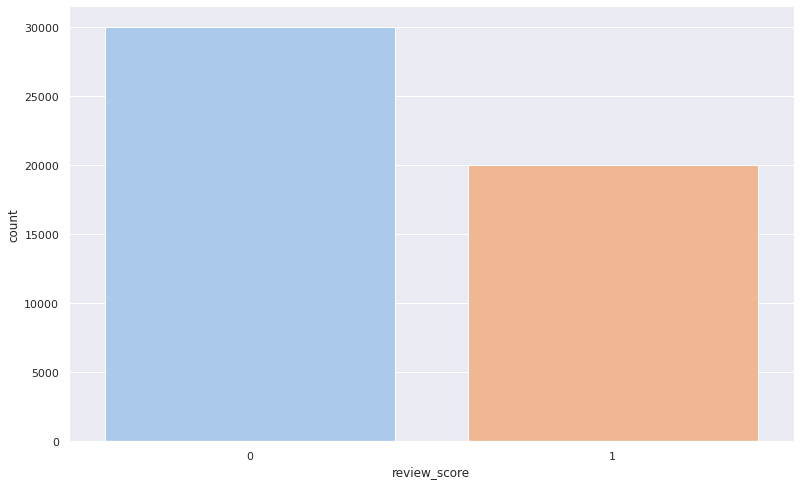

In [22]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

In [23]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

# 4. Data Cleaning For Sentiment Processing

In [24]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Null values Cleaning

In [25]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### Duplicate Values Removing

In [26]:
review = review.drop_duplicates(keep='first')

In [27]:
review.shape

(50000, 11)

### a function to clean some basic characters

In [28]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### function to remove numbers

In [29]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### function to remove emoji

In [30]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### function to unify whitespaces

In [31]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### function to remove symbols

In [32]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### function to remove punctuation

In [33]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### function to remove stopwords

In [34]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### function to use stemming to normalize words

In [35]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### combining all the cleaning functions

In [36]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [37]:
cleaning(review,'review_text')

In [38]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [39]:
review[['review_text']].head(20)

,review_text
0,pamela products beat tried gluten free product...
1,thank goodness bisquick finally went gluten fr...
2,cat serious intestinal issues needed canned fo...
3,age months little boy stopped gaining weight d...
4,ordered brezza baby food maker son middle apri...
5,pretzel shaped beef tendon big toy breed littl...
6,first exposure patchi choclates abu dhabi patc...
7,would like tell company whole box bars melted ...
8,saw online impressed ingredients ordered dogs ...
9,using baby food maker months loved easy steam ...


### Now all the cleanings are done and will try to visualize the common words distribution of our review texts.

In [40]:
review_vis2 = review.copy()

In [41]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,br,61752
1,like,25282
2,taste,17426
3,product,16776
4,one,16409
5,coffee,16282
6,good,15444
7,would,14303
8,food,12691
9,flavor,12359


<AxesSubplot:xlabel='count', ylabel='Common_words'>

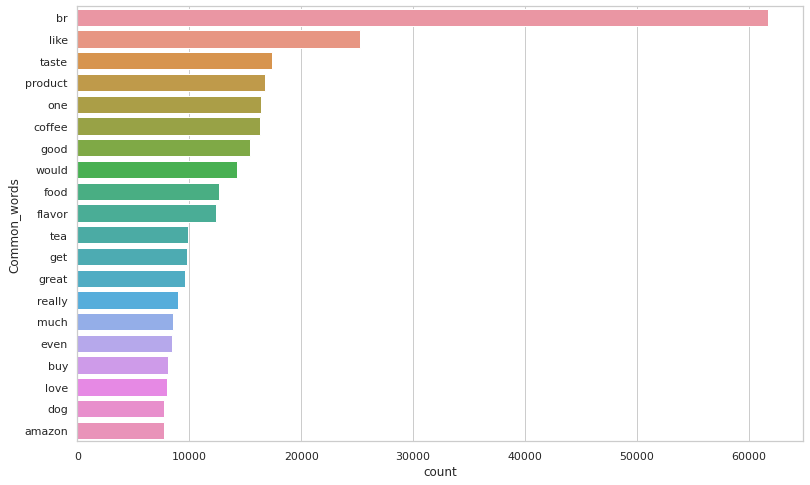

In [42]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### common words are 'br','like','taste'

# 5. BERT Tokenizing and Modelling

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


### Split Data to Training, Validation, and Hold-Out Data

In [44]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [45]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [46]:
training_labels = pd.Series(training_labels)

In [47]:
print(type(training_labels.index))

<class 'pandas.core.indexes.range.RangeIndex'>


In [48]:
num_rows_to_shuffle = int(0.5 * len(training_labels))
np.random.seed(0)  
indices_to_shuffle = np.random.choice(training_labels.index[1:], size=num_rows_to_shuffle, replace=False)
training_labels.iloc[indices_to_shuffle] = np.random.choice(training_labels, size=num_rows_to_shuffle)

In [49]:
len(indices_to_shuffle)

15000

### Tokenize Input Data

In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

In [51]:
# Example of the tokenizer output
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 2474, 1632, 3879, 5309, 1214, 1385, 1488, 1640, 7424, 1207, 2963, 2448, 2972, 4252, 22494, 2861, 3317, 1632, 3945, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [52]:
review['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [53]:
# tokenize training, validation and hold-out Texts

train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [54]:
# convert the input encodings and labels into a TensorFlow Dataset object

train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

### BERT Model Fine-Tuning

In [55]:
# initialize pre-trained BERT model

model = TFBertForSequenceClassification.from_pretrained('bert-large-cased',num_labels=2)

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [58]:
history = model.fit(train_dataset.shuffle(1000).batch(2),
          epochs=3,
          validation_data=validation_dataset.shuffle(1000).batch(2),
                    verbose=1)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


15000/15000 [==============================] - 13369s 888ms/step - loss: 0.6877 - accuracy: 0.5754 - val_loss: 0.6720 - val_accuracy: 0.6099
Epoch 2/3
15000/15000 [==============================] - 13295s 886ms/step - loss: 0.6867 - accuracy: 0.5768 - val_loss: 0.6689 - val_accuracy: 0.6099
Epoch 3/3
15000/15000 [==============================] - 13281s 885ms/step - loss: 0.6839 - accuracy: 0.5801 - val_loss: 0.6857 - val_accuracy: 0.6099


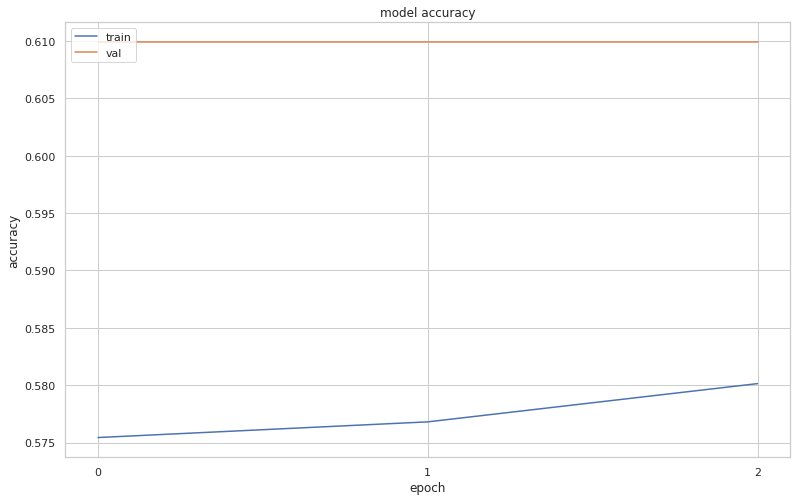

In [60]:
from matplotlib.ticker import MaxNLocator

# plot train and validation accuracy

ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
model.save_pretrained("./output_model")

### BERT Model's Performance Evaluation

In [62]:
# load the model and then evaluate it on holdout set

loaded_model = TFBertForSequenceClassification.from_pretrained("./output_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1250/1250 [==============================] - 1254s 1s/step - loss: 0.6867 - accuracy: 0.5961


{'loss': 0.6867486238479614, 'accuracy': 0.5960999727249146}

### the model's accuracy 88.94% on the holdout set (other validation set)

In [ ]:
# predict the sentiment for holdout set

tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [ ]:
# confusion matrix of our predictions

cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

### The model has a strong ability to correctly identify positive instances, with relatively few errors in misclassifying positives as negatives and vice versa. The high number of true positives and true negatives compared to false positives and false negatives indicates good performance in both detecting positives and rejecting negatives.

In [ ]:
# visualize the confusion matrix

cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# Precision, Recall, and F1-Score

tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

### The model's score with f1-score of 0.909.That's a strong F1-score, indicating the model performs well in terms of precision and recall. 